In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM,GRU
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D,MaxPooling1D,GlobalAveragePooling1D,Reshape
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_curve
from sklearn.metrics import classification_report,auc

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas:  0.23.4
numpy:  1.19.1
seaborn:  0.9.0
matplotlib:  2.2.3
sklearn:  0.19.2
Keras:  2.3.1
Tensorflow:  2.1.0


In [266]:
df=pd.read_csv("../data/ec2_cpu_utilization_77c1ca.txt", sep=",", index_col=None)
print(df.shape)
pd.options.display.max_columns = None
df.head(5)



(4032, 2)


,timestamp,value
0,2014-04-02 14:25:00,0.068
1,2014-04-02 14:30:00,0.102
2,2014-04-02 14:35:00,0.100
3,2014-04-02 14:40:00,0.098
4,2014-04-02 14:45:00,0.102


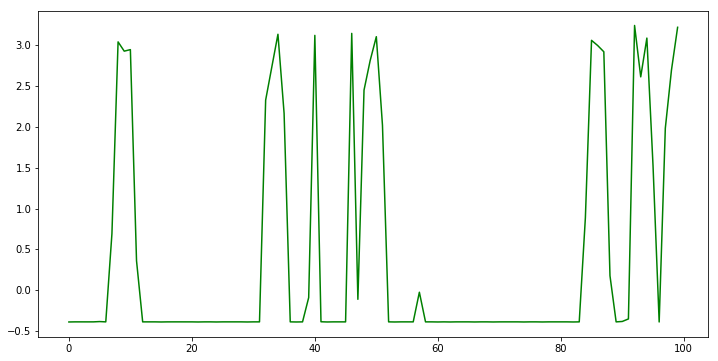

In [267]:
data= StandardScaler().fit_transform(df['value'].values.reshape(-1, 1))
plt.figure(figsize=(12,6))
plt.plot(data[0:100],color="green")

In [330]:
train=data[[data<0.5]]
train=np.array(train)
timesquence=6
trim=len(train)%timesquence
train=train[:len(train)-trim]
train.shape=(int(len(train)/timesquence),timesquence,1)
print("train",train.shape)
print(train)

train (584, 6, 1)
[[[-0.38811743]
  [-0.38685468]
  [-0.38692896]
  [-0.38700324]
  [-0.38685468]
  [-0.38321498]]

 [[-0.38692896]
  [ 0.36106658]
  [-0.38692896]
  [-0.38685468]
  [-0.38685468]
  [-0.38819171]]

 [[-0.38700324]
  [-0.38692896]
  [-0.38685468]
  [-0.38700324]
  [-0.38700324]
  [-0.38819171]]

 ...

 [[-0.38692896]
  [-0.38700324]
  [-0.38811743]
  [-0.38685468]
  [-0.38685468]
  [-0.35231466]]

 [[-0.38432917]
  [-0.38707752]
  [-0.38692896]
  [-0.38700324]
  [-0.38685468]
  [-0.38826599]]

 [[-0.38685468]
  [-0.38700324]
  [-0.38685468]
  [-0.38685468]
  [-0.38692896]
  [-0.38685468]]]


F:\anaconda\anac\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


In [331]:
test=data[0:1000]
test_label=[]
for i in range(len(test)):
    if(test[i]>0.4 ):
        test_label.append(1)
    else:
        test_label.append(0)
            
print(len(test_label))
test=np.array(test)
trim=len(test)%timesquence
test_label=test_label[:len(test)-trim]
test=test[:len(test)-trim]
test.shape=(int(len(test)/timesquence),timesquence,1)
print("test",test.shape)

1000
test (166, 6, 1)


In [332]:
LSTM

metric = 'mean_absolute_error'
model = Sequential()
model.add(LSTM(units=32, activation='relu', input_shape=(timesquence, 1), return_sequences=True))
#model.add(LSTM(units=16, activation='relu', input_shape=(timesquence, 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
 
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())


Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 6, 32)             4352      
_________________________________________________________________
dropout_48 (Dropout)         (None, 6, 32)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 6, 1)              33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [348]:
metric = 'mean_absolute_error'
model = Sequential()
model.add(GRU(units=32, activation='relu', input_shape=(timesquence, 1), return_sequences=True))
model.add(GRU(units=16,activation='relu', return_sequences=True))
#model.add(GRU(units=8,activation='relu', return_sequences=True))
model.add(Dropout(0.5))  
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_87 (GRU)                 (None, 6, 32)             3264      
_________________________________________________________________
gru_88 (GRU)                 (None, 6, 16)             2352      
_________________________________________________________________
dropout_52 (Dropout)         (None, 6, 16)             0         
_________________________________________________________________
dense_54 (Dense)             (None, 6, 1)              17        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None


In [369]:
from keras.layers import  Lambda
n_filters = 32 
filter_width = 2

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq
x = Conv1D(filters=n_filters,
               kernel_size=filter_width,
             padding='causal',
              activation='relu')(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]
pred_seq_train = Lambda(slice, arguments={'seq_length':timesquence})(x)

model = Model(history_seq, pred_seq_train)
model.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
dense_57 (Dense)             (None, None, 128)         4224      
_________________________________________________________________
dropout_54 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
dense_58 (Dense)             (None, None, 1)           129       
_________________________________________________________________
lambda_4 (Lambda)            (None, None, 1)           0         
Total params: 4,449
Trainable params: 4,449
Non-trainable params: 0
_________________________________________________________

In [370]:

history=model.fit(train, train,
                  batch_size=32,#32
                   epochs=18,#15
                    validation_data=(test, test))



Train on 584 samples, validate on 166 samples
Epoch 1/18
584/584 [==============================] - 2s 4ms/step - loss: 0.1761 - val_loss: 0.3895
Epoch 2/18
584/584 [==============================] - 0s 477us/step - loss: 0.0499 - val_loss: 0.2913
Epoch 3/18
584/584 [==============================] - 0s 494us/step - loss: 0.0327 - val_loss: 0.1959
Epoch 4/18
584/584 [==============================] - 0s 486us/step - loss: 0.0276 - val_loss: 0.1371
Epoch 5/18
584/584 [==============================] - 0s 492us/step - loss: 0.0266 - val_loss: 0.0914
Epoch 6/18
584/584 [==============================] - 0s 510us/step - loss: 0.0255 - val_loss: 0.0921
Epoch 7/18
584/584 [==============================] - 0s 511us/step - loss: 0.0244 - val_loss: 0.0949
Epoch 8/18
584/584 [==============================] - 0s 561us/step - loss: 0.0235 - val_loss: 0.0860
Epoch 9/18
584/584 [==============================] - 0s 485us/step - loss: 0.0225 - val_loss: 0.0931
Epoch 10/18
584/584 [=================

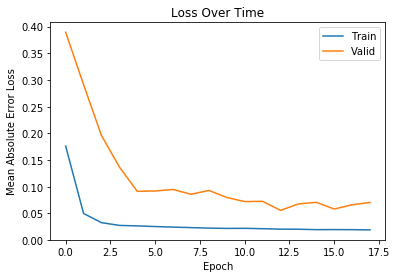

In [371]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [372]:
test_pred = model.predict(test)
print(test_pred.shape)

(166, 6, 1)


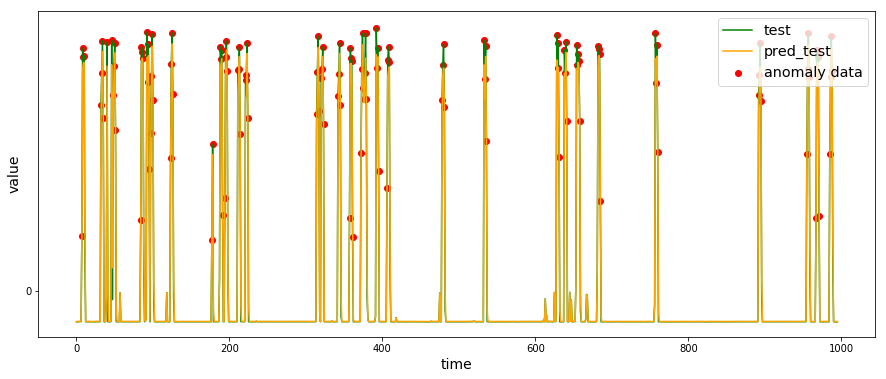

In [368]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(10)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(-0.4,-0.3)
plt.plot(test1[0:],color="green")
plt.plot(test_pred1[0:],color="orange",linestyle='-')
for i in range(len(test1)):
    if test_label[i] == 1:
        plt.scatter(i,test1[i],color="red")          
plt.legend(('test','pred_test','anomaly data'),loc='upper right',fontsize='x-large')


In [432]:
#点集检测
pred_label=[]
for i in range(len(test1)):
    pred_label.append(0)#正常

PAsum_rela_erro=np.zeros((len(pred_label)), dtype = float)
for i in range(len(pred_label)):
    PAsum_rela_erro[i]=np.abs(test1[i]-test_pred1[i])
PAscores=PAsum_rela_erro.copy()
PAscores.sort()
print(PAscores)


[0.00142793 0.00177168 0.00220445 0.0022301  0.00246631 0.00257259
 0.00259408 0.00261503 0.00296226 0.00296348 0.00319141 0.0035031
 0.00369692 0.00370635 0.00371712 0.00371712 0.00371982 0.00396188
 0.00404881 0.00405292 0.00405709 0.00406504 0.00406902 0.00407391
 0.00408527 0.00408527 0.00408527 0.00408527 0.00408527 0.00408527
 0.00408527 0.00408527 0.00408527 0.00408527 0.00408527 0.00408527
 0.00408527 0.00408527 0.00408527 0.00408527 0.00408527 0.00408527
 0.00408527 0.00408527 0.00408527 0.00408527 0.00408527 0.00408527
 0.00408527 0.00408527 0.00408527 0.00408527 0.00408527 0.00408527
 0.00408527 0.00408527 0.00408527 0.00408527 0.00408527 0.00408652
 0.00408652 0.00408652 0.00408652 0.00408652 0.00408652 0.00408652
 0.00408652 0.00408652 0.00408652 0.00408652 0.00408652 0.00408652
 0.00408652 0.00408652 0.00408652 0.00408652 0.00408652 0.00408652
 0.00408652 0.00408652 0.00408652 0.00408652 0.00408652 0.00408652
 0.00408652 0.00408652 0.00408652 0.00408652 0.00408652 0.00408

In [433]:
print(PAscores[500])

0.004474905545239105


In [434]:
PAcutoff=int(0.86*len(PAscores))
PAthreshold=PAscores[PAcutoff]
print(PAscores[PAcutoff])

0.033634281344061795


In [435]:
for i in range(len(test1)):
    if PAsum_rela_erro[i] > PAthreshold:
        pred_label[i]=2 #异常

In [436]:
normal_rela_erro=0.15
#集体集检测
timestep=20
n=int(len(pred_label)/timestep)
CAsum_rela_erro=np.zeros(n+1, dtype = float)
for i in range(0,len(test1),timestep):
    for j in range(timestep):
            if ((i+j)<len(pred_label)) and (pred_label[i+j]==0):
                rela_erro=np.abs(test1[i+j]-test_pred1[i+j])
                CAsum_rela_erro[int(i/timestep)]=rela_erro+CAsum_rela_erro[int(i/timestep)]
              #  print()
            else:
                CAsum_rela_erro[int(i/timestep)]=normal_rela_erro+CAsum_rela_erro[int(i/timestep)]
                
                
CAscores=CAsum_rela_erro.copy()
CAscores.sort()
print(CAscores)


[0.08471757 0.08564473 0.0858087  0.08613534 0.08618139 0.08628137
 0.08629305 0.08640393 0.0864068  0.08647394 0.08649045 0.0865794
 0.08663776 0.08678253 0.08690311 0.08693253 0.08704451 0.08739905
 0.08764404 0.08785105 0.09737689 0.10044038 0.37817521 0.3792208
 0.38028937 0.52401569 0.52935577 0.55301898 0.66612213 0.66870156
 0.67030736 0.67144566 0.68279815 0.69591364 0.70043763 0.70063833
 0.7060111  0.70747811 0.81213949 0.81274958 0.81443024 0.81543295
 1.10586086 1.25058815 1.25372185 1.25520244 1.26866891 1.40070997
 1.42457814 1.69970691]


In [437]:
CAcutoff=int(0.99*len(CAscores))
CAthreshold=CAscores[CAcutoff]
print(CAthreshold)

1.6997069127699784


In [438]:
for i in range(n+1):
    if CAsum_rela_erro[i] > CAthreshold:
        for j in range(timestep):
            if i*timestep+j<len(pred_label) and pred_label[i*timestep+j]!=2:
                pred_label[i*timestep+j]=1
        

In [439]:
Perro_x=[]
Perro_y=[]
Cerro_x=[]
Cerro_y=[]
for i in range(len(test1)):
    if pred_label[i]==2:
        Perro_x.append(i)
        Perro_y.append(test1[i])
    elif pred_label[i]==1:
        Cerro_x.append(i)
        Cerro_y.append(test1[i])

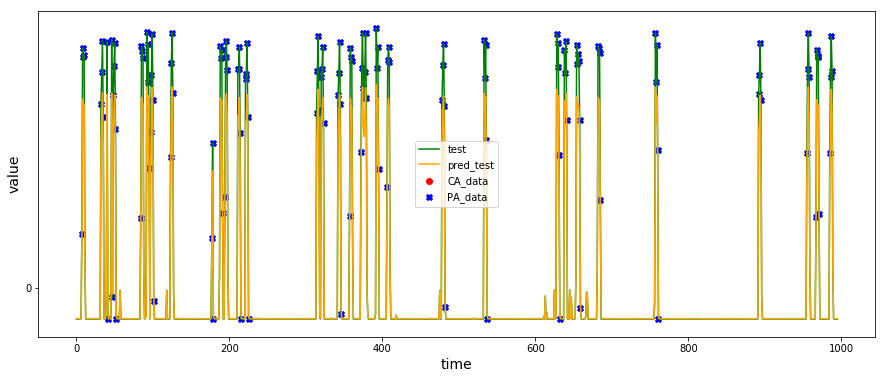

In [440]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,1000)
plt.plot(test1[0:],color="green",label='test')
plt.plot(test_pred1[0:],color="orange",linestyle='-',label='pred_test')
plt.scatter(Cerro_x,Cerro_y,color="red",label='CA_data')
plt.scatter(Perro_x,Perro_y,color="blue",marker="X",label='PA_data')          
plt.legend()


In [441]:
Pred_label=[]
for i in range(len(pred_label)):
    if pred_label[i]==0:
        Pred_label.append(0)
    else:
        Pred_label.append(1)

In [442]:
print("CA:",pred_label.count(1))
print("PA:",pred_label.count(2))
ROC=roc_auc_score(test_label,Pred_label)
print("ROC_AUC score:{:2%}".format(ROC))  
precision, recall, _thresholds = precision_recall_curve(test_label, Pred_label)
PR_AUC = auc(recall, precision)
print("PR-AUC score:{:2%}".format(PR_AUC)) 

CA: 0
PA: 139
ROC_AUC score:98.858313%
PR-AUC score:94.980241%


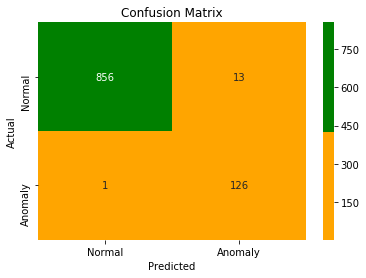

In [443]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(6, 4))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

viz = Visualization()
viz.draw_confusion_matrix(test_label,Pred_label)